In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import numpy as np
from scipy.signal import wiener
from tqdm import tqdm
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import bm3d
from skimage.exposure import match_histograms

sys.path.append(str(Path("..").resolve()))
from src import *

# Fourier Transform

In [2]:
FRAMES = 300
x_path = DATASETS["synthetic"].dir / "noise_1Q_-5.52dBSNR_490x490x6000.tif"
y_path = DATASETS["synthetic"].dir / "deepcad_E_10_test.tif"
gt_path = DATASETS["synthetic"].dir / "clean_30Hz_490x490x6000.tif"
x, y, gt = (Recording(_, max_frames=FRAMES) for _ in [x_path, y_path, gt_path])
RES_DIR = Path("results/synthetic/")
RES_DIR.mkdir(exist_ok=True)

In [3]:
fft_x = np.fft.fft(x.np, axis=0)
fft_abs_x = np.abs(fft_x)
fft_angle_x = np.angle(fft_x, deg=True)
del fft_x
fft_y = np.fft.fft(y.np, axis=0)
fft_abs_y = np.abs(fft_y)
fft_angle_y = np.angle(fft_y, deg=True)
del fft_y

In [4]:
dt = 1 / 30  # Synthetic is 30Hz
freqs = np.fft.fftfreq(x.np.shape[0], d=dt)
rfft_abs_x = fft_abs_x[freqs >= 0]
rfft_abs_y = fft_abs_y[freqs >= 0]
rfft_angle_x = fft_angle_x[freqs >= 0]
rfft_angle_y = fft_angle_y[freqs >= 0]

In [30]:
# 19s for 6000
AVG = 3000
x_mean = np.mean(Recording(x_path, max_frames=AVG).np, axis=0)
# x_mean = (x_mean - np.min(x_mean)) / (np.max(x_mean) - np.min(x_mean))
# x_mean = (x_mean * (np.max(rfft_abs_x[0]) - np.min(rfft_abs_x[0]))) + np.min(rfft_abs_x[0])

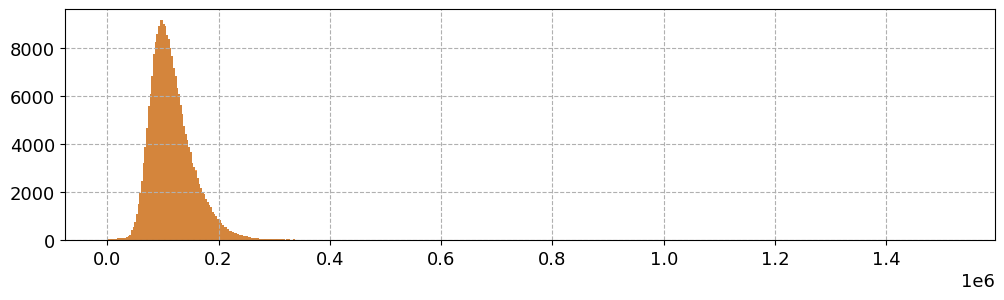

In [16]:
ax = pd.Series(x_mean.flatten()).hist(bins=500, figsize=(12, 3), alpha=0.75)
pd.Series(rfft_abs_x[0].flatten()).hist(bins=500, ax=ax, alpha=0.75);

In [15]:
x_mean = match_histograms(x_mean, rfft_abs_x[0])

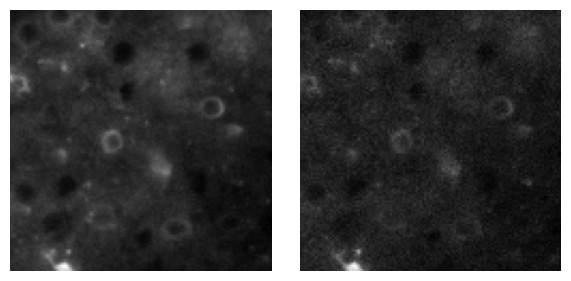

In [31]:
imshow([x_mean, rfft_abs_x[0]], zoom=4, size=3)

### The magnitude of the lowest-freq frame can be taken from RAW

In [8]:
np.save(RES_DIR/f"{FRAMES}_freq0_avg{AVG}.npy", fft_abs_x[0])

In [ ]:
alpha = 1.
fft_abs = fft_abs_y.copy()

fft_abs[0] = alpha * x_mean + (1 - alpha) * fft_abs_y[0]
# for f in [1, 2]:
    # fft_abs[f] = alpha * fft_abs_x[f] + (1 - alpha) * fft_abs_y[f]
X = fft_abs * np.exp(1j * np.deg2rad(fft_angle_y))
fused = np.fft.ifft(X, axis=0).real

In [10]:
del fft_abs_x, fft_angle_x

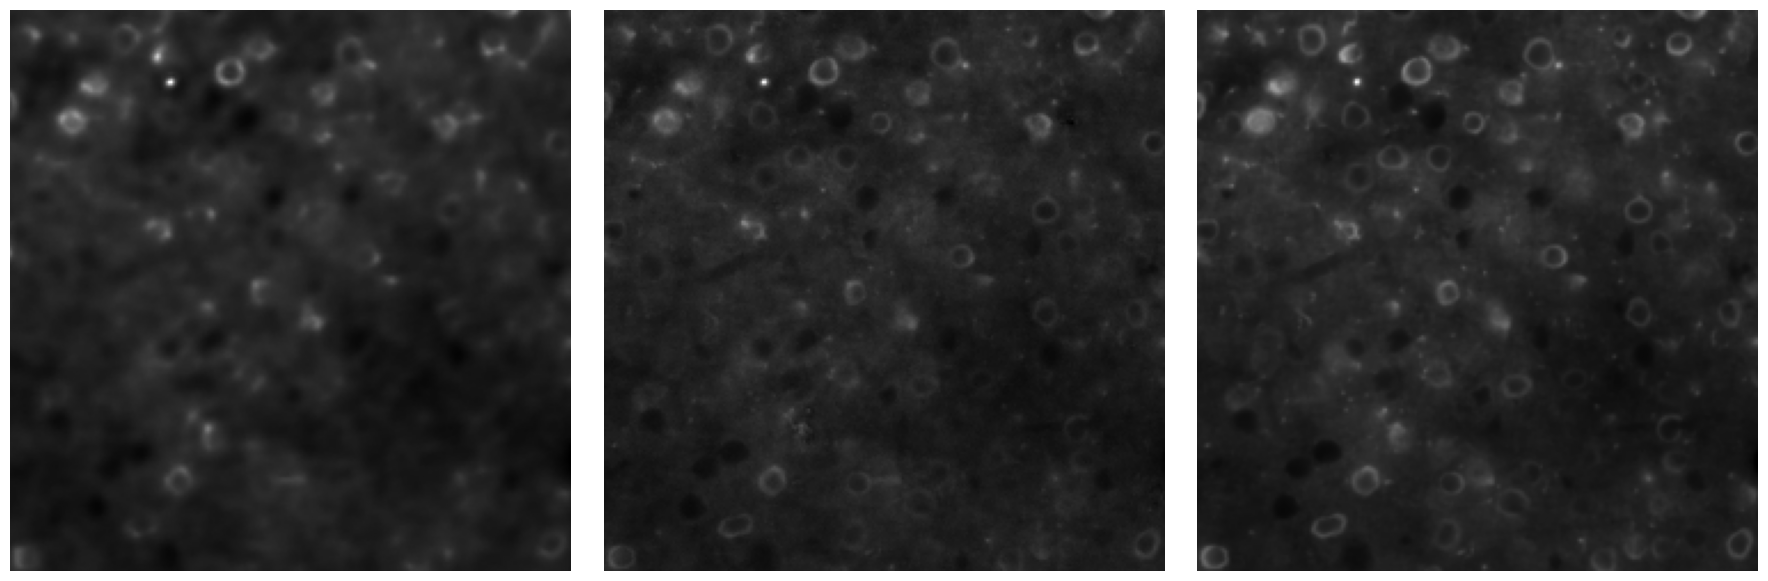

In [12]:
imshow([y.np[100], fused[100], gt.np[100]], size=6, zoom=2)

In [19]:
y.render(RES_DIR /f"y.mp4", fps=30)
x.render(RES_DIR / f"x.mp4", fps=30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (490, 490) to (496, 496) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
x265 [info]: HEVC encoder version 3.5+1-f0c1022b6
x265 [info]: build info [Linux][GCC 8.3.0][64 bit] 8bit+10bit+12bit
x265 [info]: using cpu capabilities: MMX2 SSE2Fast LZCNT SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
x265 [info]: Main profile, Level-3 (Main tier)
x265 [info]: Thread pool created using 12 threads
x265 [info]: Slices                              : 1
x265 [info]: frame threads / pool features       : 3 / wpp(8 rows)
x265 [warning]: Source height < 720p; disabling lookahead-slices
x265 [info]: Coding QT: max CU size, min CU size : 64 / 8
x265 [info]: Residual QT: max TU size, max depth : 32 / 1 inter / 1 intra
x265 [info]: ME / range / subpel / merge         : hex / 57

In [13]:
suffx = f"{FRAMES}_avg{AVG}"

In [20]:
if not (RES_DIR / f"fft_fusion_{suffx}.mp4").exists():
    Recording(fused).render(RES_DIR / f"fft_fusion_{suffx}.mp4", fps=30)
Editor().alternate(
    {
        "DeepCAD": RES_DIR / "y.mp4",
        "FFT Fused": RES_DIR / f"fft_fusion_{suffx}.mp4",
    },
    RES_DIR / f"fft_fusion_{suffx}_alt.mp4",
    bitrate=4000,
    codec="libx265",
    delta=1.5,
)
Editor().compose(
    [
        {
            "DeepCAD": RES_DIR / "y.mp4",
            "FFT Fused": RES_DIR / f"fft_fusion_{suffx}.mp4",
        }
    ],
    RES_DIR / f"fft_fusion_{suffx}_comb.mp4",
    bitrate=4000,
    codec="libx265",
)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (490, 490) to (496, 496) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
x265 [info]: HEVC encoder version 3.5+1-f0c1022b6
x265 [info]: build info [Linux][GCC 8.3.0][64 bit] 8bit+10bit+12bit
x265 [info]: using cpu capabilities: MMX2 SSE2Fast LZCNT SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
x265 [info]: Main profile, Level-3 (Main tier)
x265 [info]: Thread pool created using 12 threads
x265 [info]: Slices                              : 1
x265 [info]: frame threads / pool features       : 3 / wpp(8 rows)
x265 [warning]: Source height < 720p; disabling lookahead-slices
x265 [info]: Coding QT: max CU size, min CU size : 64 / 8
x265 [info]: Residual QT: max TU size, max depth : 32 / 1 inter / 1 intra
x265 [info]: ME / range / subpel / merge         : hex / 57

Moviepy - Building video results/synthetic/fft_fusion_600_avg6000_alt.mp4.
Moviepy - Writing video results/synthetic/fft_fusion_600_avg6000_alt.mp4



Moviepy - Done !
Moviepy - video ready results/synthetic/fft_fusion_600_avg6000_alt.mp4
Moviepy - Building video results/synthetic/fft_fusion_600_avg6000_comb.mp4.
Moviepy - Writing video results/synthetic/fft_fusion_600_avg6000_comb.mp4



Moviepy - Done !
Moviepy - video ready results/synthetic/fft_fusion_600_avg6000_comb.mp4


In [21]:
np.save(RES_DIR / f"fused_{alpha}_{suffx}_mean.npy", fused)